In [1]:
# Implementing the network structure from the paper https://arxiv.org/abs/1704.02019
# Associative Content Addressable Memory with Exponentially Many Robust Stable States
# By Rishidev Chaudhuri and Ila Fiete

In [2]:
# Goint in to really solve the oscillation issue
# I suspect the issue is this: http://www.robertmarks.org/REPRINTS/1987_SynchronousVsAsynchonousBehavior.pdf
# I am going to try to fix it with asynchronous operation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm # color maps

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
global_num_timesteps = 600

In [5]:
# Bottom layer has N neurons, called input neurons
# Second layer is constraint layer, has N_c ~ N small sub-networks
# The small sub-networks are called constraint nodes
# ith input neuron connects to z_i constraint nodes
# jth constraint node connects to z_j_c input neurons

# Each neuron in a given constraint node is connected to the same set of input neurons

# M is the number of neurons in each constraint node

N = 16
N_c = 6
z = 5
z_c_avg = 13
r = 5
M_typical = 256


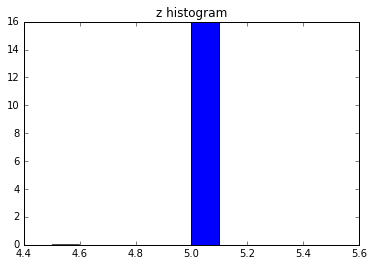


total outgoing edges
80


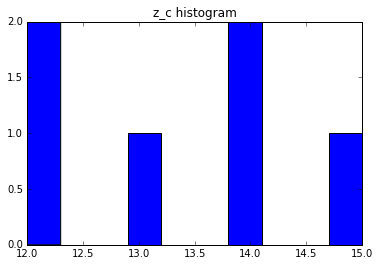


total incoming edges
80


In [6]:
# First define the input to constraint node connectivity

N = 16
print "N = %i" % N

N_c = int(5*N/12)
print "N_c = %i" % N_c

z = 5
print "z = %i" % z

z_c_avg = int(N*z/N_c)
print "z_c_avg = %i" % z_c_avg

r = 5
print "r = %i" % r

M_typical = 2**(z_c_avg-r)
print "M_typical = %i" % M_typical

input_to_constraint_node_connectivity = []
for i in range(N):
    input_to_constraint_node_connectivity.append(np.ndarray.tolist(np.random.choice(range(N_c), size = z, replace = False)))
    
constraint_node_to_input_connectivity = []
for i in range(N_c):
    temp = []
    for j in range(N):
        if i in input_to_constraint_node_connectivity[j]:
            temp.append(j)
    constraint_node_to_input_connectivity.append(temp)
    
plt.figure()
plt.title("z histogram")
plt.hist([len(q) for q in input_to_constraint_node_connectivity])
plt.show()

print "\ntotal outgoing edges"
print np.sum([len(q) for q in input_to_constraint_node_connectivity])

plt.figure()
plt.title("z_c histogram")
plt.hist([len(q) for q in constraint_node_to_input_connectivity])
plt.show()

print "\ntotal incoming edges"
print np.sum([len(q) for q in constraint_node_to_input_connectivity])

In [7]:
def generate_random_parity_states(input_size, num_parity_states_to_generate):
    parity_states = []
    for i in range(num_parity_states_to_generate):
        parity = 1
        state = []
        while parity == 1:
            state = np.random.randint(0,2,size = input_size)
            parity = sum(state) % 2
            if parity == 0:
                parity_states.append(state)

    return parity_states

print generate_random_parity_states(12, 1)

[array([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1])]


In [8]:
def M_for_constraint_node(constraint_node_index):
    z_c_for_this_node = len(constraint_node_to_input_connectivity[constraint_node_index])
    return 2**(z_c_for_this_node - r)

In [9]:
def generate_constraint_node_neurons(constraint_node_index):
    neurons = []
    z_c_for_this_node = len(constraint_node_to_input_connectivity[constraint_node_index])
    M_for_this_node = M_for_constraint_node(constraint_node_index)
    for i in range(M_for_this_node):
        neuron = {}
        neuron["inputs"] = constraint_node_to_input_connectivity[constraint_node_index]
        neuron["num_inputs"] = len(neuron["inputs"])
        neuron["preferred_parity_config"] = generate_random_parity_states(neuron["num_inputs"], 1)[0]
        neuron["ons_preferred"] = [neuron["inputs"][j] for j in range(neuron["num_inputs"]) if neuron["preferred_parity_config"][j] == 1] 
        neuron["offs_preffered"] = [neuron["inputs"][j] for j in range(neuron["num_inputs"]) if neuron["preferred_parity_config"][j] == 0]
        neuron["bias_term"] = neuron["num_inputs"] - np.sum(neuron["preferred_parity_config"])
        neurons.append(neuron)

    return neurons

print generate_constraint_node_neurons(N_c-1)[0]

{'offs_preffered': [4, 9, 10, 12, 13, 14], 'inputs': [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14], 'ons_preferred': [0, 1, 2, 3, 5, 6, 7, 11], 'num_inputs': 14, 'preferred_parity_config': array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]), 'bias_term': 6}


In [10]:
def get_full_index(constraint_node_index, index_within_node):
    return N + sum([M_for_constraint_node(k) for k in range(constraint_node_index)]) + index_within_node

In [11]:
# Generating the full weight matrix and biases

last_constraint_node_index = N_c-1

last_neuron_in_last_constraint_node_index = M_for_constraint_node(last_constraint_node_index) - 1

total_number_neurons = get_full_index(last_constraint_node_index, last_neuron_in_last_constraint_node_index) + 1
total_number_neurons = int(total_number_neurons) # Not sure why it is making me do this
print "total number of neurons %i" % total_number_neurons
 
full_weight_matrix = [[0.0 for j in range(total_number_neurons)] for i in range(total_number_neurons)]

biases = [0.0 for j in range(total_number_neurons)]

for node in range(N_c): # Index over constraint nodes
    neurons_in_node = generate_constraint_node_neurons(node) # Generate neurons in that constraint node
    z_c_for_this_node = len(constraint_node_to_input_connectivity[node])
    M_for_this_node = M_for_constraint_node(node)
    for m in range(M_for_this_node):
        neuron_full_index = get_full_index(node, m)
        neuron = neurons_in_node[m]
        for g in neuron["ons_preferred"]: # Constraint neuron to input neuron and vice versa
            full_weight_matrix[neuron_full_index][g] = 1
            full_weight_matrix[g][neuron_full_index] = 1
        for g in neuron["offs_preffered"]: # Constraint neuron to input neuron and vice versa
            full_weight_matrix[neuron_full_index][g] = -1
            full_weight_matrix[g][neuron_full_index] = -1
        for p in range(m, M_for_this_node): # Inhibitory internal connectivity within the same node
            p_full_index = get_full_index(node, p)
            if p != m:
                full_weight_matrix[neuron_full_index][p_full_index] = -1*(neuron["num_inputs"] - 1)
                full_weight_matrix[p_full_index][neuron_full_index] =  -1*(neuron["num_inputs"] - 1)
        biases[neuron_full_index] = neuron["bias_term"]

total number of neurons 2576


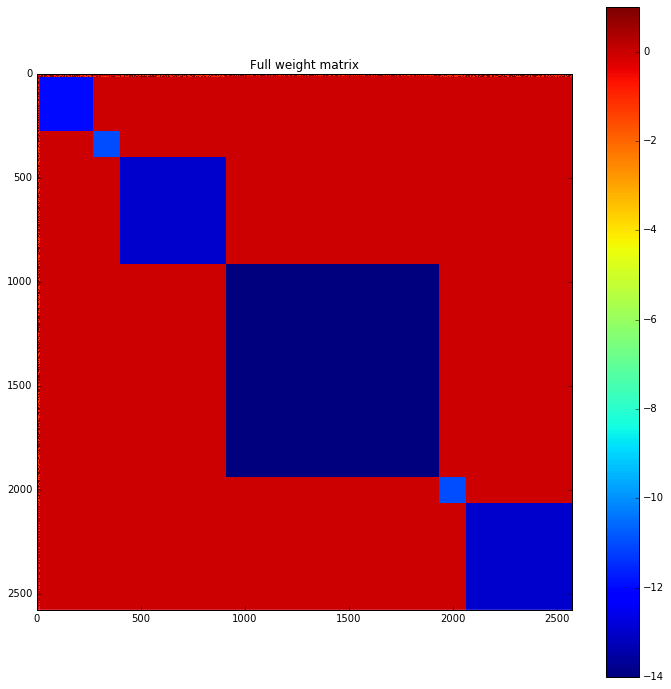

In [12]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.figure()
plt.title("Full weight matrix")
plt.imshow(full_weight_matrix, interpolation='none')
plt.colorbar()
plt.show()

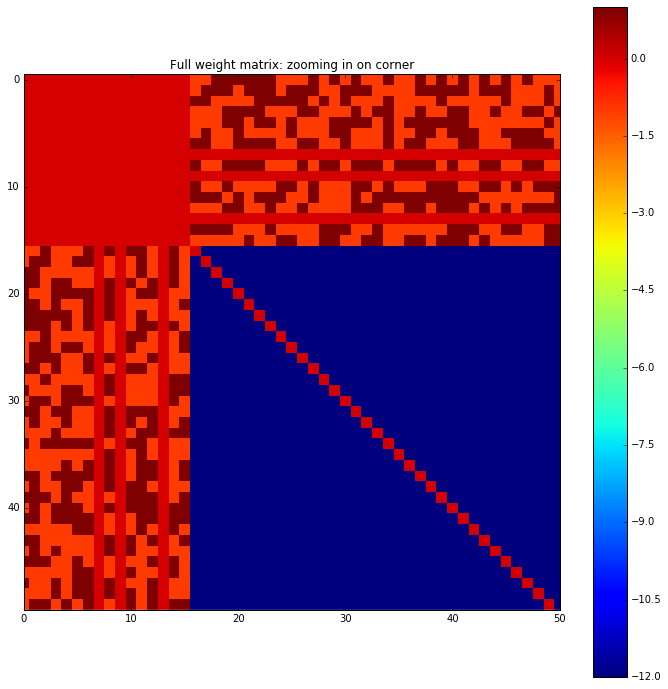

In [13]:
plt.figure()
plt.title("Full weight matrix: zooming in on corner")
corner = full_weight_matrix[:50][:50]
plt.imshow(corner, interpolation='none')
plt.xlim(0.0, 50.0)
plt.colorbar()
plt.show()

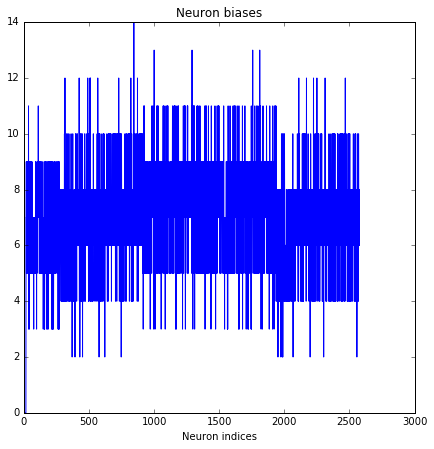

In [14]:
plt.rcParams['figure.figsize'] = (7, 7)
plt.figure()
plt.title("Neuron biases")
plt.xlabel("Neuron indices")
plt.plot(biases)
plt.show()

In [15]:
# Defining some Hopfield aspects

def random_state(num_neurons):
    return np.ndarray.tolist(np.random.randint(0,2,size = num_neurons))

activation_plot_counter = 0

def time_step(state, weight_matrix, biases): # Asynchronous mode

    k = np.random.randint(0, len(state), size=1)[0] # Pick a random single neuron to update
    
    a = 0.0
    for j in range(len(state)):
        if j != k:
            a += weight_matrix[k][j] * state[j]
    a += biases[k]
        
    ns = state
        
    if a > 0.0:
        ns[k] = 1.0
    elif a < 0.0:
        ns[k] = 0.0
    elif a == 0.0: # If the activation is exactly zero
        coin_flip = float(np.random.randint(0,2, size=1)[0])
        ns[k] = coin_flip
                        
    return ns

def old_synchronous_time_step(state, weight_matrix, biases, plot_contrib = False): # Synchronous mode
    new_activations = []
    ns = []
    
    for k in range(len(state)):
        n = 0.0
        for j in range(len(state)):
            if j != k:
                n += weight_matrix[k][j] * state[j]
        n += biases[k]
        new_activations.append(n)
    
    if plot_contrib:
        plt.xlabel("Neuron index")
        plt.ylabel("Non-thresholded activation")
        plt.plot(new_activations, label = activation_plot_counter, linewidth = 2)
        
    for k in range(len(state)):
        a = new_activations[k]
        if a > 0.0:
            ns.append(1.0)
        elif a < 0.0:
            ns.append(0.0)
        elif a == 0.0: # If the activation is exactly zero
            coin_flip = float(np.random.randint(0,2, size=1)[0])
            ns.append(coin_flip)
            # ns.append(state[k]) # Alternative to the stochastic choice?
                        
    return ns

def energy(s, weights, bias):
    s_plusminus = [(-1)**q for q in s]
    x = np.array(s_plusminus)
    W = np.array(weights)
    b = np.array(bias)
    E = (1/2) * np.matmul(np.matmul(np.transpose(x), W), x) + np.dot(x,b)
    return E 

def small_perturbation(perturb_size, state):
    new_state = np.zeros(len(state))
    prob = float(perturb_size)/float(len(state))
    for i in range(len(state)):
        if np.random.rand() < prob:
            new_state[i] = (state[i] + 1) % 2
        else:
            new_state[i] = state[i]
    return new_state

energy -336.000000 [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
energy 1254.000000 [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0.0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]

___Starting again from the exact same (random) initial state___
energy -336.000000 [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
energy 1266.000000 [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0.0, 0, 0, 0, 0, 0, 1]

-------Effect of perturbation-------
energy 1266.000000
[ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
energy 2652.000000 [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.]


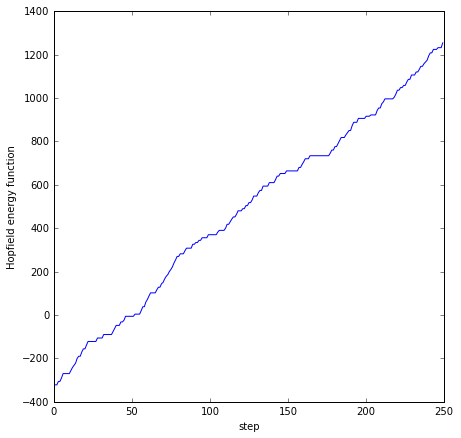

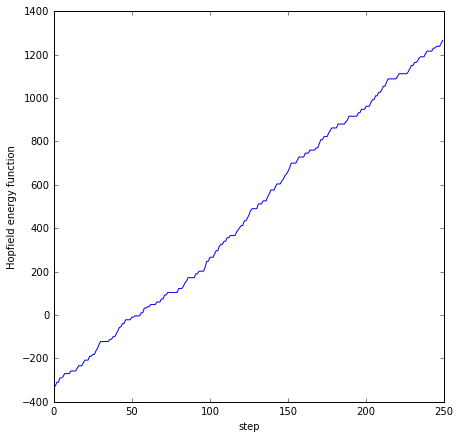

In [16]:
# Test out some Hopfield dynamics on this
initial_random_state = random_state(total_number_neurons)

num_timesteps = global_num_timesteps
state = initial_random_state[:]
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state    
print "energy %f" % e, new_state[:2*N]


plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.plot(energies)

print "\n___Starting again from the exact same (random) initial state___"

num_timesteps = global_num_timesteps
state = initial_random_state[:]
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.plot(energies)
    
found_state = state[:]
perturbed_found_state = small_perturbation(1, found_state)

print "\n-------Effect of perturbation-------"

num_timesteps = global_num_timesteps
state = perturbed_found_state
print "energy %f" % energy(state, full_weight_matrix, biases)
print state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    state = new_state
print "energy %f" % energy(new_state, full_weight_matrix, biases), new_state[:2*N]

energy 17966.000000 [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
energy 17966.000000 [1, 1, 0.0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1.0, 1, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

____Starting again from the exact same (random) initial state____
energy 17966.000000 [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
energy 17966.000000 [1, 1, 0, 0, 1, 0, 0, 0.0, 0, 1, 1, 1, 0, 0, 1, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

-------Effect of perturbation-------
energy 17966.000000
[ 1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
energy 17966.000000 [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

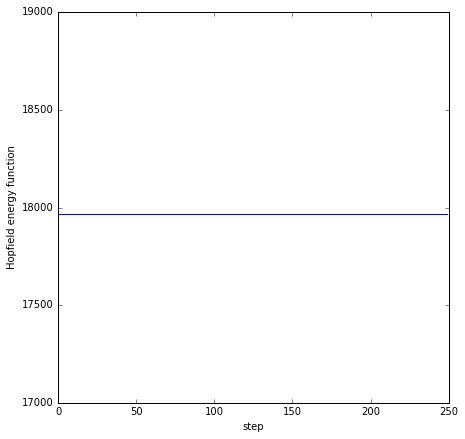

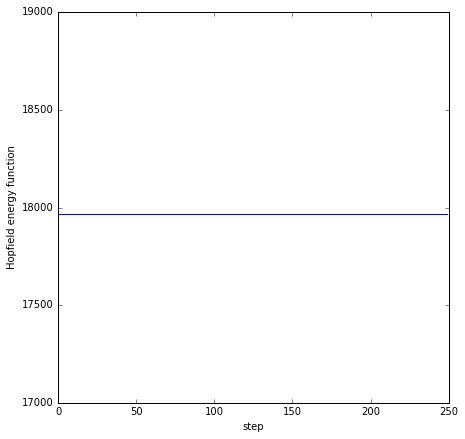

In [ ]:
# A better way of initializing the constraint nodes
initial_nonrandom_state = random_state(N) # Visible nodes random
initial_nonrandom_state.extend([0.0 for j in range(total_number_neurons - N)])
for node in range(N_c): # Set just one neuron in each constraint node to be 1
    M_for_this_node = M_for_constraint_node(node)
    m = np.random.randint(0,M_for_this_node)
    neuron_full_index = get_full_index(node, m)
    initial_nonrandom_state[neuron_full_index] = 1.0
        
num_timesteps = global_num_timesteps
state = initial_nonrandom_state[:]
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.plot(energies)

print "\n____Starting again from the exact same (random) initial state____"
num_timesteps = global_num_timesteps
state = initial_nonrandom_state[:]
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.plot(energies)
    
found_state = state[:]
perturbed_found_state = small_perturbation(1, found_state)

print "\n-------Effect of perturbation-------"

num_timesteps = global_num_timesteps
state = perturbed_found_state
print "energy %f" % energy(state, full_weight_matrix, biases)
print state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    state = new_state
print "energy %f" % energy(new_state, full_weight_matrix, biases), new_state[:2*N]

In [ ]:
# A better way of initializing the constraint nodes
initial_nonrandom_state = [0.0 for j in range(N)] # Visible nodes zero
initial_nonrandom_state.extend([0.0 for j in range(total_number_neurons - N)])
for node in range(N_c): # Set just one neuron in each constraint node to be 1
    M_for_this_node = M_for_constraint_node(node)
    m = np.random.randint(0,M_for_this_node)
    neuron_full_index = get_full_index(node, m)
    initial_nonrandom_state[neuron_full_index] = 1.0
        
num_timesteps = global_num_timesteps
state = initial_nonrandom_state[:]
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.plot(energies)

print "\n____Starting again from the exact same (random) initial state____"
plt.figure()

num_timesteps = global_num_timesteps
state = initial_nonrandom_state[:]
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
print "energy %f" % e, new_state[:2*N]
    
plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.plot(energies)
    
found_state = state[:]
perturbed_found_state = small_perturbation(1, found_state[:])

print "\n-------Effect of perturbation-------"

num_timesteps = global_num_timesteps
state = perturbed_found_state[:]
print "energy %f" % energy(state, full_weight_matrix, biases)
print state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    state = new_state
print "energy %f" % energy(new_state, full_weight_matrix, biases), new_state[:2*N]
    
perturbed_found_state = small_perturbation(5, found_state[:])

print "\n\n-------Effect of perturbation-------"

num_timesteps = global_num_timesteps
state = perturbed_found_state[:]
print "energy %f" % energy(state, full_weight_matrix, biases)
print state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    state = new_state
print "energy %f" % energy(new_state, full_weight_matrix, biases), new_state[:2*N]
    
perturbed_found_state = small_perturbation(10, found_state[:])

print "\n\n-------Effect of perturbation-------"

num_timesteps = global_num_timesteps
state = perturbed_found_state[:]
print "energy %f" % energy(state, full_weight_matrix, biases)
print state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    state = new_state
print "energy %f" % energy(new_state, full_weight_matrix, biases), new_state[:2*N]

energy 17990.000000 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
